In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/DAE_SpeechEnhancement/data"

print("Folders in data directory:")
print(os.listdir(BASE_PATH))


Folders in data directory:
['noisy_testset_wav.zip', 'clean_testset_wav.zip', 'clean_trainset_28spk_wav.zip', 'clean_trainset_28spk_wav', 'clean_testset_wav', 'noisy_testset_wav']


Sample rate: 16000
Audio shape: (32000,)


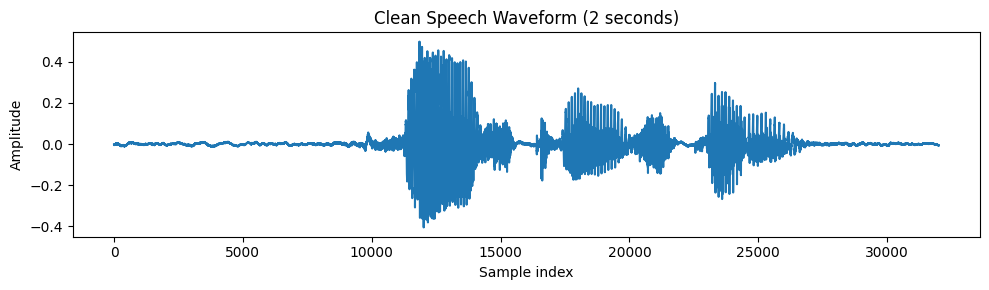

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Paths
BASE_PATH = "/content/drive/MyDrive/DAE_SpeechEnhancement/data"
CLEAN_TRAIN_PATH = os.path.join(BASE_PATH, "clean_trainset_28spk_wav")

# Parameters
SAMPLE_RATE = 16000
DURATION = 2.0
NUM_SAMPLES = int(SAMPLE_RATE * DURATION)

# Load ONE audio file
sample_file = os.listdir(CLEAN_TRAIN_PATH)[0]
sample_path = os.path.join(CLEAN_TRAIN_PATH, sample_file)

audio, sr = librosa.load(sample_path, sr=SAMPLE_RATE)

# Trim or pad to fixed length
if len(audio) > NUM_SAMPLES:
    audio = audio[:NUM_SAMPLES]
else:
    audio = np.pad(audio, (0, NUM_SAMPLES - len(audio)))

print("Sample rate:", sr)
print("Audio shape:", audio.shape)

# Visualise waveform
plt.figure(figsize=(10, 3))
plt.plot(audio)
plt.title("Clean Speech Waveform (2 seconds)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


Log-Mel spectrogram shape: (80, 126)


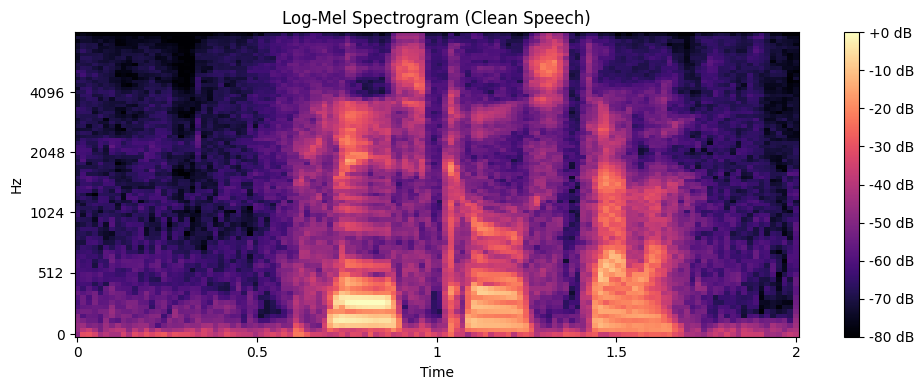

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Log-Mel spectrogram parameters
N_MELS = 80
N_FFT = 512
HOP_LENGTH = 256

# Create Mel spectrogram
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)

# Convert to log scale (dB)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

print("Log-Mel spectrogram shape:", log_mel_spec.shape)

# Visualise
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    log_mel_spec,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram (Clean Speech)")
plt.tight_layout()
plt.show()


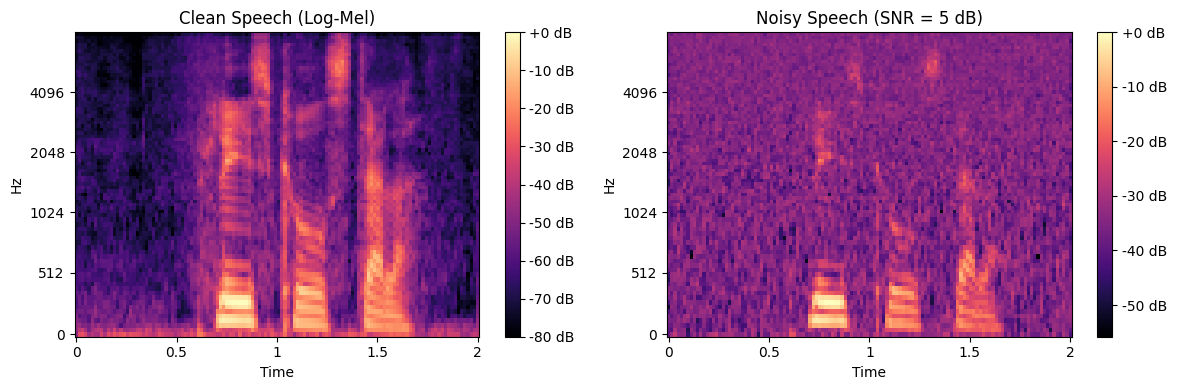

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# --- Noise function (simple & standard) ---
def add_noise(clean_audio, snr_db):
    signal_power = np.mean(clean_audio ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), clean_audio.shape)
    return clean_audio + noise

# Add noise at 5 dB SNR
SNR_DB = 5
noisy_audio = add_noise(audio, SNR_DB)

# Extract log-Mel for noisy audio
noisy_mel = librosa.feature.melspectrogram(
    y=noisy_audio,
    sr=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)
noisy_log_mel = librosa.power_to_db(noisy_mel, ref=np.max)

# --- Visual comparison ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    log_mel_spec,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.title("Clean Speech (Log-Mel)")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    noisy_log_mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.title(f"Noisy Speech (SNR = {SNR_DB} dB)")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset

class SpeechDataset(Dataset):
    def __init__(self, clean_dir):
        self.clean_dir = clean_dir
        self.files = os.listdir(clean_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load clean audio
        file_path = os.path.join(self.clean_dir, self.files[idx])
        clean_audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)

        # Fix length
        if len(clean_audio) > NUM_SAMPLES:
            clean_audio = clean_audio[:NUM_SAMPLES]
        else:
            clean_audio = np.pad(clean_audio, (0, NUM_SAMPLES - len(clean_audio)))

        # Add noise (random SNR)
        snr = np.random.choice([0, 5, 10])
        noisy_audio = add_noise(clean_audio, snr)

        # Extract log-Mel features
        clean_mel = librosa.feature.melspectrogram(
            y=clean_audio,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )
        clean_log_mel = librosa.power_to_db(clean_mel, ref=np.max)

        noisy_mel = librosa.feature.melspectrogram(
            y=noisy_audio,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )
        noisy_log_mel = librosa.power_to_db(noisy_mel, ref=np.max)

        return (
            torch.tensor(noisy_log_mel, dtype=torch.float32),
            torch.tensor(clean_log_mel, dtype=torch.float32)
        )


In [ ]:
dataset = SpeechDataset(CLEAN_TRAIN_PATH)

noisy_sample, clean_sample = dataset[0]

print("Noisy shape :", noisy_sample.shape)
print("Clean shape :", clean_sample.shape)


Noisy shape : torch.Size([80, 126])
Clean shape : torch.Size([80, 126])


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,
    batch_size=1,     # keep 1 for clear visualisation
    shuffle=True
)

print("DataLoader ready")


DataLoader ready


In [ ]:
noisy_batch, clean_batch = next(iter(train_loader))

print("Noisy batch shape :", noisy_batch.shape)
print("Clean batch shape :", clean_batch.shape)


Noisy batch shape : torch.Size([1, 80, 126])
Clean batch shape : torch.Size([1, 80, 126])


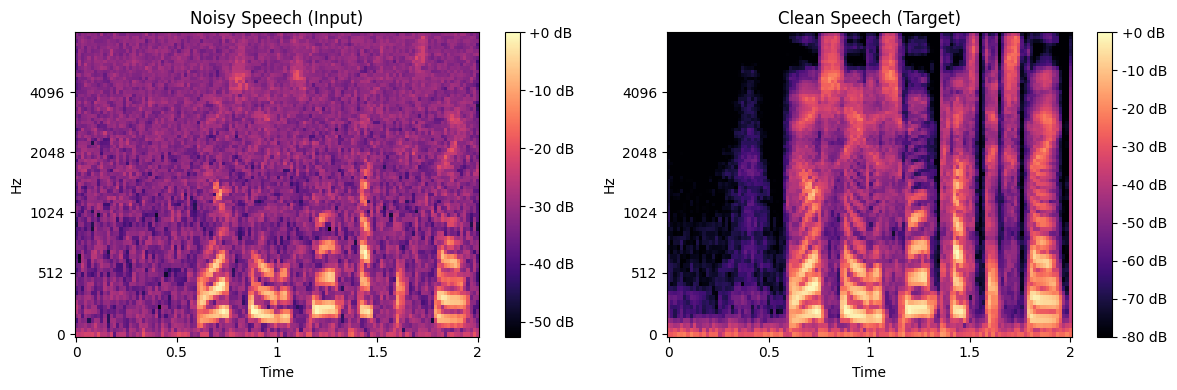

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    noisy_batch[0].numpy(),
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.title("Noisy Speech (Input)")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    clean_batch[0].numpy(),
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.title("Clean Speech (Target)")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # -------- Decoder --------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        input_T = x.shape[-1]      # original time dimension
        x = self.encoder(x)
        x = self.decoder(x)
        x = x[:, :, :, :input_T]   # crop to match input size
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenoisingAutoencoder().to(device)
print("Using device:", device)


Using device: cuda


In [ ]:
# Get one sample from DataLoader
noisy_batch, clean_batch = next(iter(train_loader))

# Add channel dimension and move to GPU
noisy_batch = noisy_batch.unsqueeze(1).to(device)   # (1, 1, 80, T)
clean_batch = clean_batch.unsqueeze(1).to(device)

# Forward pass
with torch.no_grad():
    output = model(noisy_batch)

print("Input shape :", noisy_batch.shape)
print("Output shape:", output.shape)
print("Target shape:", clean_batch.shape)


Input shape : torch.Size([1, 1, 80, 126])
Output shape: torch.Size([1, 1, 80, 126])
Target shape: torch.Size([1, 1, 80, 126])


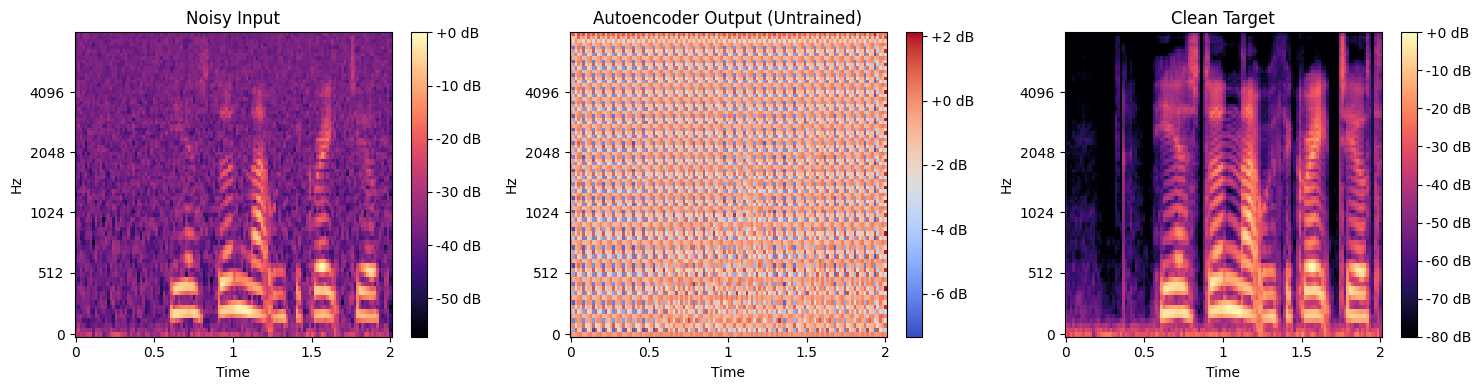

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
librosa.display.specshow(
    noisy_batch[0, 0].cpu().numpy(),
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("Noisy Input")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 2)
librosa.display.specshow(
    output[0, 0].cpu().numpy(),
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("Autoencoder Output (Untrained)")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 3)
librosa.display.specshow(
    clean_batch[0, 0].cpu().numpy(),
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("Clean Target")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


Epoch [1/10] - Loss: 226.1058
Epoch [2/10] - Loss: 178.3058
Epoch [3/10] - Loss: 159.5390
Epoch [4/10] - Loss: 152.5058
Epoch [5/10] - Loss: 151.3354
Epoch [6/10] - Loss: 148.3435
Epoch [7/10] - Loss: 147.4217
Epoch [8/10] - Loss: 146.7608
Epoch [9/10] - Loss: 145.5334
Epoch [10/10] - Loss: 144.8737


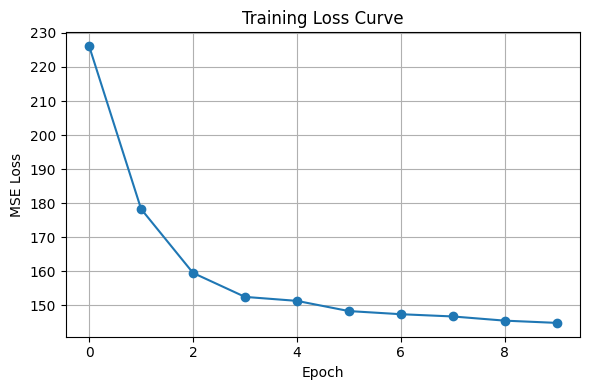

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training settings
EPOCHS = 10   # keep small for now
loss_history = []

model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for noisy_batch, clean_batch in train_loader:
        noisy_batch = noisy_batch.unsqueeze(1).to(device)
        clean_batch = clean_batch.unsqueeze(1).to(device)

        # Forward pass
        output = model(noisy_batch)
        loss = criterion(output, clean_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

# ---- Plot training loss ----
plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import librosa
import numpy as np
import torch
import librosa.display
import matplotlib.pyplot as plt

# Test paths
NOISY_TEST_PATH = os.path.join(BASE_PATH, "noisy_testset_wav")
CLEAN_TEST_PATH = os.path.join(BASE_PATH, "clean_testset_wav")

# Pick one test file
test_file = os.listdir(NOISY_TEST_PATH)[0]

noisy_path = os.path.join(NOISY_TEST_PATH, test_file)
clean_path = os.path.join(CLEAN_TEST_PATH, test_file)

# Load audio
noisy_audio, _ = librosa.load(noisy_path, sr=SAMPLE_RATE)
clean_audio, _ = librosa.load(clean_path, sr=SAMPLE_RATE)

# Fix length
if len(noisy_audio) > NUM_SAMPLES:
    noisy_audio = noisy_audio[:NUM_SAMPLES]
    clean_audio = clean_audio[:NUM_SAMPLES]
else:
    noisy_audio = np.pad(noisy_audio, (0, NUM_SAMPLES - len(noisy_audio)))
    clean_audio = np.pad(clean_audio, (0, NUM_SAMPLES - len(clean_audio)))


In [ ]:
# Noisy spectrogram
noisy_mel = librosa.feature.melspectrogram(
    y=noisy_audio,
    sr=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)
noisy_log_mel = librosa.power_to_db(noisy_mel, ref=np.max)

# Clean spectrogram
clean_mel = librosa.feature.melspectrogram(
    y=clean_audio,
    sr=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)
clean_log_mel = librosa.power_to_db(clean_mel, ref=np.max)


In [ ]:
# Prepare input tensor
noisy_tensor = torch.tensor(noisy_log_mel, dtype=torch.float32)
noisy_tensor = noisy_tensor.unsqueeze(0).unsqueeze(0).to(device)

# Model inference
model.eval()
with torch.no_grad():
    enhanced_tensor = model(noisy_tensor)

enhanced_log_mel = enhanced_tensor[0, 0].cpu().numpy()


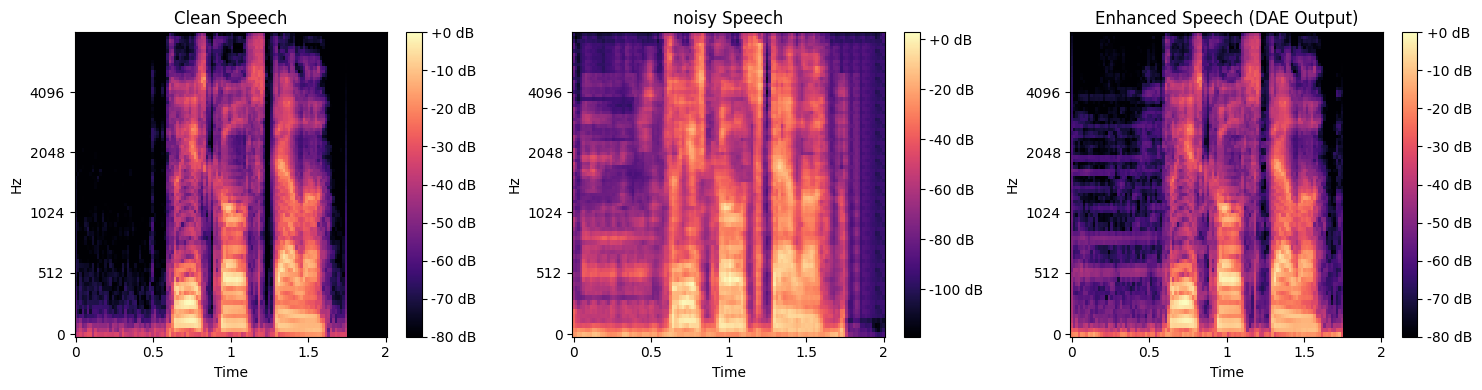

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
librosa.display.specshow(
    clean_log_mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("Clean Speech")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 2)
librosa.display.specshow(
    enhanced_log_mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("noisy Speech")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 3)
librosa.display.specshow(
    noisy_log_mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    y_axis="mel",
    x_axis="time"
)
plt.title("Enhanced Speech (DAE Output)")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np

# ----- MSE function -----
def mse(a, b):
    return np.mean((a - b) ** 2)

# Compute MSE values
mse_noisy = mse(noisy_log_mel, clean_log_mel)
mse_enhanced = mse(enhanced_log_mel, clean_log_mel)

print(f"MSE (enhanced vs clean): {mse_noisy:.2f}")
print(f"MSE (noisy vs Clean): {mse_enhanced:.2f}")

# Improvement
improvement = mse_enhanced - mse_noisy
print(f"MSE Improvement: {improvement:.2f}")


MSE (enhanced vs clean): 54.96
MSE (noisy vs Clean): 117.55
MSE Improvement: 62.59
